### Deep Mutational Scanning of Illumina Amplicon Sequencing Data

This notebook starts from one or more **Illumina amplicon sequencing datasets**, consisting of paired-end **FASTQ files** (forward reads: R1, reverse reads: R2).

Please make sure to download the input dataset `Illumina` from the Zenodo repository and place it in a folder named `data` at root repository level.

To begin processing, run the script `0_Illumina_preprocess_and_align_reads.py`, which performs:
1. **Demultiplexing** and **quality filtering** of reads
2. **Alignment** of reads to the reference sequence using `blastn`

For more details, see the `README.md` file in this repository.

The full downstream analysis is also automated in the script `1_Illumina_analyze_mutation_enrichment.py`.

---

#### This notebook includes the following steps:
- Detection of insertions and deletions  
- Calculation of mutation enrichment across the sequence  
- Computation of per-position mutation rates  
- Analysis of the mutational spectrum  
- Visualizations of the above results


---


### Notebook Setup

In [10]:
# --- Import necessary modules ---
import os
import sys
import json
import pickle as pkl
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
from Bio.SeqIO import QualityIO

notebook_dir = Path().resolve()
repo_root = notebook_dir.parent.parent 
sys.path.append(str(repo_root))

from scripts.utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
from scripts.Illumina_functions import *
from scripts.linker_analysis_functions import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

### Load and organize BLAST alignment results

In [7]:
# ======================== ANALYSIS PARAMETERS ========================

# --- Path to input FASTQ files and config ---
experiment = 'LOV_Linker_Library_Mutagenesis_10-8'
homedir = repo_root / 'data' / 'Illumina' / experiment


Bc = "BC1" # Barcode to be analyzed (must match one used during demultiplexing)
read_dirs = ["R1", "R2"] # Read directions to include in the analysis
Section = "S1" # Section/amplicon to be analyzed
data_type = "AA" # Mutation type: "AA" = amino acids, "DNA" = nucleotides


all_alignments = {}

# --- Sequence region of interest ---
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "cggccaaa".upper()

# --- Load variant information from config ---
with open(f"{homedir}/config.json") as f:
  config = json.load(f)

variant = config["variant"]

# --- Output folder for storing figures and results generated by the notebook ---
FigFolder = f"{repo_root}/final_output/{variant}_w_nb/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

In [ ]:
# ====================== LOAD AND FILTER BLAST ALIGNMENTS ======================

# --- Container to store parsed alignment and coverage data for each read direction ---
all_alignments = {}
all_coverages = {}

# --- Loop through both read directions: R1 and R2 ---
for read_dir in read_dirs:

    # --- Load BLAST output JSON file ---
    print("################",  read_dir,   "################")
    with open( f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    # --- Load the reference DNA sequence ---
    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)
    
    # --- Translate DNA reference to amino acid sequence if needed ---
    amplicon_AA = translate_dna2aa(amplicon_seq)

    # --- Extract BLAST hits from the loaded JSON ---
    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
    
    # --- Define start and end indices of the LOV2 region within the DNA reference ---
    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    # --- Filter BLAST hits: keep only those that span the LOV2 region with a ±10 nt margin ---
    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    # --- Parse and restructure alignments to extract aligned sequences and coverage data ---
    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)
    
    # --- Store the results per read direction ---
    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages

################ R1 ################
39192 alignments before filtering for LOV2 insertion site
27038 alignments after filtering for LOV2 insertion site
80 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence.
################ R2 ################
37017 alignments before filtering for LOV2 insertion site
23581 alignments after filtering for LOV2 insertion site
61 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence.


### Analyze BLAST alignments  
Note: this analysis is also fully automated when running `2_Illumina_analyze_mutation_enrichment.py`

In [4]:
# ====================== CHARACTERIZE MUTATIONAL ENRICHMENTS ======================

# --- Dictionary to store enrichment results from both read directions ---
all_enrichments = {"R1":{}, "R2":{}}

# --- Loop through each read direction (R1 and R2) ---
for read_dir in read_dirs: 

    # --- Analyze alignments: get all variant calls, indels, and enrichment metrics ---
    all_variants, indels,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir, exclude_not_covered_regions=False)
   
    # --- Store results in a structured dictionary ---
    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels"] = indels
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative

# ====================== COMBINE R1 AND R2 ENRICHMENTS ======================

# --- Set correct reference depending on analysis type ---
reference = amplicon_AA if data_type == "AA" else amplicon_seq

# --- Combine variant counts from R1 and R2 ---
total_variants = all_enrichments[read_dirs[0]]["all_variants"] + all_enrichments[read_dirs[1]]["all_variants"]

# --- Combine enrichment counts from R1 and R2 
total_enrichment = all_enrichments[read_dirs[0]]["enrichment_counts"] + all_enrichments[read_dirs[1]]["enrichment_counts"]

# --- Calculate relative enrichment (mutation frequency per position) ---
total_relative_enrichment = total_enrichment/total_variants.sum()

# ====================== COMBINE INDELS ======================

# --- Sum indel counts from both read directions ---
total_indels = all_enrichments[read_dirs[0]]["indels"] + all_enrichments[read_dirs[1]]["indels"]

# --- Calculate indel frequency using total raw coverage before filtering ---
total_indels_freq = total_indels/(all_coverages[read_dirs[0]]+all_coverages[read_dirs[1]]) # here, we use the coverage calculated before indel reads were filtered out

# ====================== MASK LOW-COVERAGE POSITIONS ======================

# --- Get total coverage per position ---
enrichment_coverages = total_variants.sum()

# --- Set enrichment values to NaN for positions with coverage below threshold (e.g. 2000 reads) ---
total_relative_enrichment.loc[:,enrichment_coverages < 2000] = np.nan

675 sequences with off target indels are excluded
26283 sequences are included in the enrichment analysis
943 sequences with off target indels are excluded
22577 sequences are included in the enrichment analysis


### Plot mutation enrichment heatmap

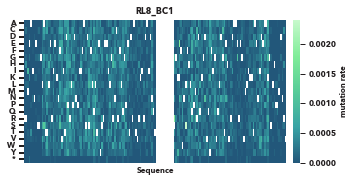

In [6]:
plot_mutation_enrichment(total_relative_enrichment, 
                         ref_seq=reference, 
                         samplename=f"{variant}_{Bc}", 
                         data_type=data_type, 
                         FigFolder=FigFolder, 
                         vmax=None, 
                         cmap = custom_cmap)

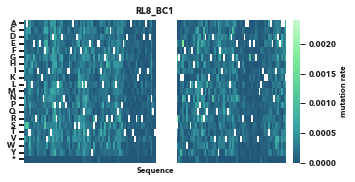

In [8]:
# ====================== OPTIONAL: FILTER TO REGION OF INTEREST (ROI) ======================

# --- Determine start and end indices for the region of interest ---
# For DNA: use nucleotide indices; for AA: divide by 3 to get codon/amino acid position
roi_startidx = LOV2_startidx if data_type == "DNA" else LOV2_startidx//3
roi_endidx = LOV2_endidx if data_type == "DNA" else LOV2_endidx//3

# --- Slice the enrichment matrix to keep only the ROI columns ---
total_relative_enrichment_roi = total_relative_enrichment.iloc[:,roi_startidx:roi_endidx]

plot_mutation_enrichment(total_relative_enrichment_roi, 
                         ref_seq=reference[roi_startidx:roi_endidx], 
                         samplename=f"{variant}_{Bc}", 
                         data_type=data_type, 
                         FigFolder=FigFolder, 
                         vmax=None, 
                         cmap = custom_cmap)

### Plot INDEL frequencies

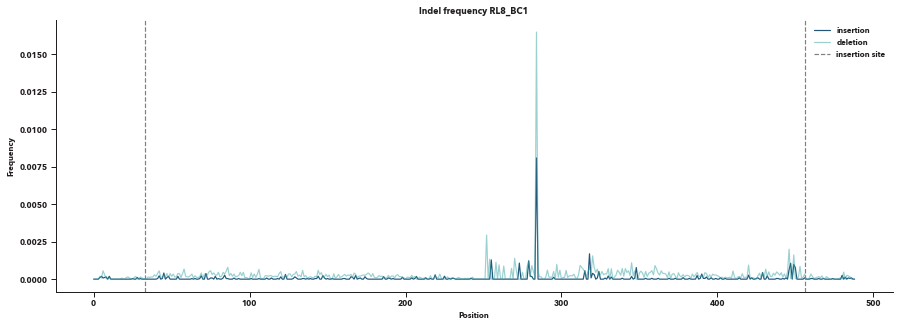

In [9]:
# --- Plot the frequency of insertions and deletions across the sequence ---
# This function highlights the region of interest (LOV2) by two vertical, grey lines
plot_indel_freqs(
    total_indels_freq,                                # y-values: indel frequency per position
    filename=f"{variant}_{Bc}",                       # output name
    FigFolder=FigFolder,                              # folder to save the plot
    roi_start_idx=LOV2_startidx,                      # start index of region of interest
    roi_end_idx=LOV2_endidx,                          # end index of region of interest
    color1="#22577A",                               # insertion color
    color2="#38A3A5"                                # deletion color
)

# --- Display the plot inline ---
plt.show()

### Calculate and plot mutational spectrum

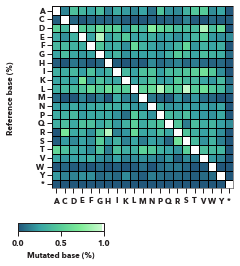

In [ ]:
# --- Fill NaN values with 0 for downstream calculations ---
# NaNs typically come from positions filtered out due to low coverage
total_relative_enrichment.fillna(0, inplace=True)

# --- Compute the mutational spectrum from the enrichment matrix ---
_, mut_spectrum_perc = calc_mut_spectrum_from_enrichment(
    total_relative_enrichment,
    ref_seq=reference,
    data_type=data_type
)

# --- Plot the mutational spectrum as heatmap ---
plot_mutation_spectrum(
    mut_spectrum_perc,
    data_type=data_type,
    colormap=custom_cmap 
)

### Plot the coverage

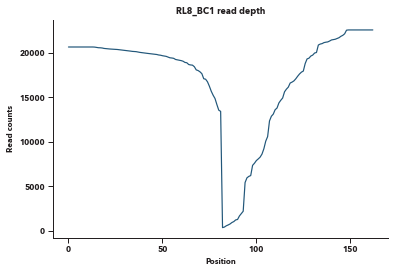

In [ ]:
coverage_plot(total_variants.sum(), 
              FigFolder=FigFolder, 
              samplename = f"{variant}_{Bc}", 
              color = "#22577A")

### Analysis of mutations encoded in the DMS-library
Here, we analyze the mutations (also (for the DMS-library non-targeted) insertions/deletions) that are encoded in the DMS-library. We start from the aligned reads from the RAMPhaGE_Plasmid_Library_NGS sequencing run (Barcode 3 of that sequencing run refers to the DMS-library). We analyze the encoded mutations (and indels) on the *DNA* level.

In [8]:
# --- Define path to the home directory of input data ---
experiment = "RAMPhaGE_Plasmid_Library_NGS"
homedir = repo_root / 'data' / 'Illumina' / experiment


with open(f"{homedir}/config.json") as f:
    config = json.load(f)


# --- Define analysis identifiers ---
Bc = "BC3" # BC3 refers to the DMS-library 
read_dir = "R1" # only forward read is used due to higher quality
variant = "RetronLib"
section = "S1"
blast_alignments = []

# --- Load BLAST output JSON file containing alignments ---
with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{section}_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# --- Check data structure type (should be dict) ---
print(type(blast_output)) 

# --- Extract list of alignments from BLAST output ---
blast_alignments_read_dir = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()

# --- Extract list of alignments from BLAST output ---
ref_alignment_region = config["amplicon"]

# --- Define start and end positions for the LOV2 insertion site ---
LOV_startseq = "ttagccacaa".upper()
LOV_endseq = "cggccaaa".upper()
LOV2_start_idx = ref_alignment_region.index(LOV_startseq)
LOV2_end_idx = ref_alignment_region.index(LOV_endseq) + len(LOV_endseq)

# --- Define output folder for figures and data ---
FigFolder = f"{repo_root}/final_output/RAMPhaGE_Plasmid_Library_NGS/{Bc}_{read_dir}/blastpipeline/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)  

# --- Combine alignments from current read direction ---
blast_alignments = blast_alignments + blast_alignments_read_dir

# --- Initialize mutation and coverage counters ---
RL_encoded_mutations = [0]*len(ref_alignment_region)  # mismatches per position
RL_encoded_insertions = [0]*len(ref_alignment_region) # insertions per position
RL_encoded_deletions = [0]*len(ref_alignment_region)  # deletions per position
coverage = [0]*len(ref_alignment_region)              # coverage per position

# --- Loop through all alignments and analyze mismatches and indels ---
print("total reads:", len(blast_alignments))
for alignment in blast_alignments:
    qseq = alignment["hsps"][0]["qseq"].upper()
    hseq = alignment["hsps"][0]["hseq"].upper()
    seq_id = alignment["description"][0]["title"]
    midline = alignment["hsps"][0]["midline"]

    query_from  = alignment["hsps"][0]["query_from"] -1 # convert to 0-based index
    query_to = alignment["hsps"][0]["query_to"]

    # --- Update coverage count ---
    for pos in range(query_from, query_to):
        coverage[pos] += 1
    
    # --- Handle insertions and deletions ---
    if "-" in qseq or "-" in hseq:
        shift = 0  # correction for index shifting due to insertions

        for i, nt in enumerate(qseq):
            pos = query_from + i - shift
            if hseq[i] == "-":
                RL_encoded_deletions[pos] += 1 ## here, no shift + 1 needed since deletions in the **read** do not infere with the indexing when mappping to the **reference** (no shift of the ref position)
            if nt == "-":
                RL_encoded_insertions[pos] += 1  # Mark insertion at the previous reference position
                shift += 1  # Increase shift due to insertion  
    # --- Handle substitutions only (no indels) ---
    else: 
        hotencoding = [0 if midline[i] == "|" else 1 for i in range(len(midline))]
        for pos, val in enumerate(hotencoding):
            RL_encoded_mutations[query_from + pos] += val
        
# if not os.path.exists(f"{FigFolder}/enrichments/"):
    # os.makedirs(f"{FigFolder}/enrichments/")
# pd.DataFrame(RL_encoded_deletions).to_csv(f"{FigFolder}/enrichments/{Bc}_RL_encoded_deletions.csv")
# pd.DataFrame(RL_encoded_insertions).to_csv(f"{FigFolder}/enrichments/{Bc}_RL_encoded_insertions.csv")
# pd.DataFrame(RL_encoded_mutations).to_csv(f"{FigFolder}/enrichments/{Bc}_RL_encoded_mutations.csv")

<class 'dict'>
total reads: 5794
